In [79]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


### Datos

In [80]:
import random
random.seed(42)
ticker = 'CL=F'

data = yf.download(ticker, start='2022-01-01', end='2025-04-07', progress=False)
close_prices = data['Close']

S0 = close_prices.iloc[-1]

S0



Ticker
CL=F    61.990002
Name: 2025-04-04 00:00:00, dtype: float64

In [81]:
returns = close_prices.pct_change().dropna()
sigma = returns.std() * np.sqrt(252)
T = 1
K = 65
num_steps = 252
r = 0.0425
n_sims = 10000
dt = T / num_steps
Z = np.random.normal(size=(n_sims, num_steps))

### Función

In [82]:
def simulate_prices(S0, r, sigma, T, num_steps, n_sims):
    dt = T / num_steps
    Z = np.random.normal(size=(n_sims, num_steps)) ## parámetros estándar : 0 y 1
    simulated_returns = (r - 0.5 * sigma.iloc[0]**2) * dt + sigma.iloc[0] * np.sqrt(dt) * Z
    simulared_cumulative_returns = np.cumsum(simulated_returns, axis=1)
    simulated_prices = S0.iloc[0] * np.exp(simulared_cumulative_returns)
    return simulated_prices


def get_price__fixed_strike__average_price(simulated_prices, K, r, T, option_type):
    avg_prices = np.mean(simulated_prices[:, 1:], axis=1)

    if option_type == 'call':
        payoffs = np.maximum(avg_prices - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - avg_prices, 0)

    option_price =  np.exp(-r * T) * np.mean(payoffs)

    return option_price



def get_price__floating_strike__average_price(simulated_prices, St, r, T, option_type):
    avg_prices = np.mean(simulated_prices[:, 1:], axis=1)
    if option_type == 'call':
        payoffs = np.maximum(avg_prices - St, 0)
    elif option_type == 'put':
        payoffs = np.maximum(St - avg_prices, 0)
    option_price =  np.exp(-r * T) * np.mean(payoffs)

    return option_price

def get_price__fixed_strike__geometric_price(simulated_prices, K, r, T, option_type):
    geometric_prices = np.exp(np.mean(np.log(simulated_prices[:, 1:]), axis=1))
    if option_type == 'call':
        payoffs = np.maximum(geometric_prices - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - geometric_prices, 0)
    option_price =  np.exp(-r * T) * np.mean(payoffs)

    return option_price

def get_price__floating_strike__geometric_price(simulated_prices, St, r, T, option_type):
    geometric_prices = np.exp(np.mean(np.log(simulated_prices[:, 1:]), axis=1))
    if option_type == 'call':
        payoffs = np.maximum(geometric_prices - St, 0)
    elif option_type == 'put':
        payoffs = np.maximum(St - geometric_prices, 0)
    option_price =  np.exp(-r * T) * np.mean(payoffs)

    return option_price


def get_price__european(simulated_prices, K, r, T, option_type):
    St = simulated_prices[:, -1]
    if option_type == 'call':
        payoffs = np.maximum(St - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - St, 0)
    option_price =  np.exp(-r * T) * np.mean(payoffs)

    return option_price    


### Precios prima

In [83]:
simulated_prices = simulate_prices(S0, r, sigma, T, num_steps, n_sims)
St= simulated_prices[:, -1]
get_price__fixed_strike__average_price(simulated_prices, K, r, T, 'call')

4.596675895320171

In [84]:
get_price__floating_strike__average_price(simulated_prices, St, r, T, 'call')


4.488200101338468

In [85]:
get_price__fixed_strike__geometric_price(simulated_prices, K, r, T, 'call')


4.229110596097707

In [86]:
get_price__floating_strike__geometric_price(simulated_prices, St, r, T, 'call')


4.168587249055843

In [87]:
get_price__european(simulated_prices, K, r, T, 'call')


8.989940489567713

### Gráfica Call

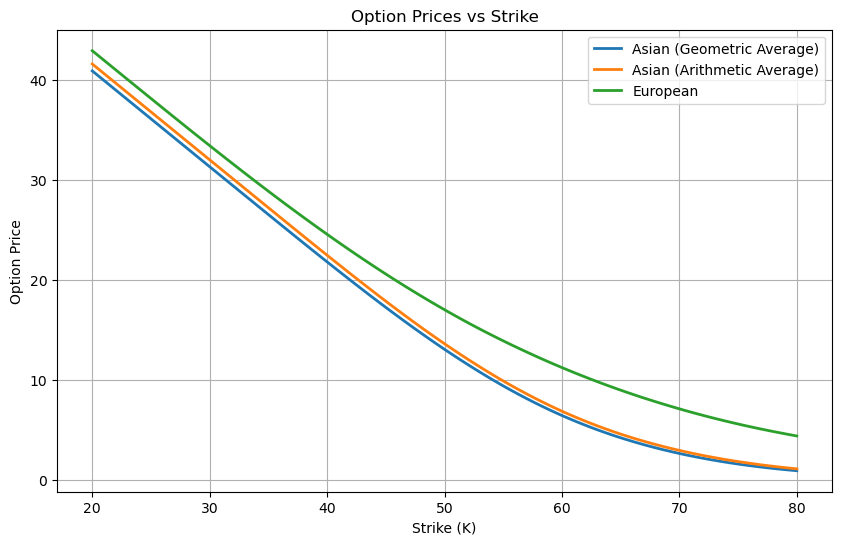

In [88]:
K_rango = np.linspace(20, 80, 100)
geometrica = []
aritmetica = []
europea = []

for K in K_rango:
    geometrica.append(get_price__fixed_strike__geometric_price(simulated_prices, K, r, T, 'call'))
    aritmetica.append(get_price__fixed_strike__average_price(simulated_prices, K, r, T, 'call'))
    europea.append(get_price__european(simulated_prices, K, r, T, 'call'))

plt.figure(figsize=(10, 6))
plt.plot(K_rango, geometrica, label='Asian (Geometric Average)', linewidth=2)
plt.plot(K_rango, aritmetica, label='Asian (Arithmetic Average)', linewidth=2)
plt.plot(K_rango, europea, label='European', linewidth=2)
plt.xlabel('Strike (K)')
plt.ylabel('Option Price')
plt.title('Option Prices vs Strike')
plt.legend()
plt.grid(True)
plt.show()


En este caso podemos ver para las opciones call las opcines más baratas son las geometricas, después le siguen las opciones aritmeticas y las más caras son las opciones europeas. 

### Gráfica Put

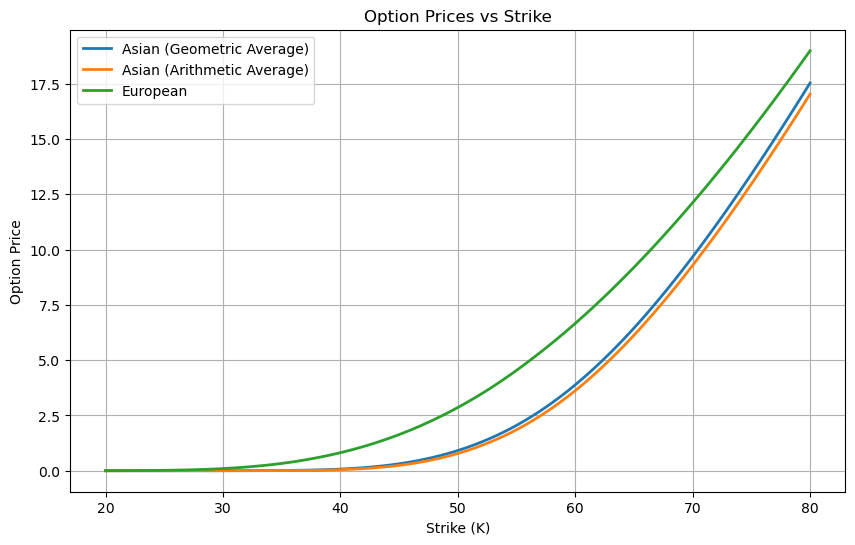

In [89]:
K_rango = np.linspace(20, 80, 100)
geometrica = []
aritmetica = []
europea = []

for K in K_rango:
    geometrica.append(get_price__fixed_strike__geometric_price(simulated_prices, K, r, T, 'put'))
    aritmetica.append(get_price__fixed_strike__average_price(simulated_prices, K, r, T, 'put'))
    europea.append(get_price__european(simulated_prices, K, r, T, 'put'))

plt.figure(figsize=(10, 6))
plt.plot(K_rango, geometrica, label='Asian (Geometric Average)', linewidth=2)
plt.plot(K_rango, aritmetica, label='Asian (Arithmetic Average)', linewidth=2)
plt.plot(K_rango, europea, label='European', linewidth=2)
plt.xlabel('Strike (K)')
plt.ylabel('Option Price')
plt.title('Option Prices vs Strike')
plt.legend()
plt.grid(True)
plt.show()

Podemos ver que si afecta si los cambios en el tipo de opciones cambian ya que ahora que usamos un tipo de opcion put, la opción más barata son las aritmeticas, después le siguen las geometricas y lo que si se mantiene es que las opciones más caras son las europeas. 

#### Conclusión

Podemos ver en las gráficas que la europea se mantiene como la opción más cara ya sea con calls o puts, sin embargo las opciones de media aritmetica y geometrica cambian de lugar, siendo en los call, la geometrica más barata y en los puts, la aritmetica la más barata. Esto se puede deber a lo que se espera como actuen los subyacentes, y por el valor de las medias. Por lo general la media geometrica es menor a la aritmetica, por lo cual en las opcines call, hace que su valor se reduzca, es por esto que es la más barata. Por otro lado, en los puts esto se cambia, dando com resultado que la aritmetica sea la menor. 

### St promedio

In [90]:
St = np.mean(simulated_prices[:, -1])
St

64.78786262022821

#### Call

In [91]:
import pandas as pd
prices= pd.DataFrame({
    'European': get_price__european(simulated_prices, 65, r, T, 'call'),
    'Asian (Arithmetic)': get_price__fixed_strike__average_price(simulated_prices, 65, r, T, 'call'),
    'Asian (Geometric)': get_price__fixed_strike__geometric_price(simulated_prices, 65, r, T, 'call'),
    'Asian (Floating Strike)': get_price__floating_strike__average_price(simulated_prices, St, r, T, 'call'),
    'Asian (Floating Geometric)': get_price__floating_strike__geometric_price(simulated_prices, St, r, T, 'call'),
}, index =['precio'])
prices

,European,Asian (Arithmetic),Asian (Geometric),Asian (Floating Strike),Asian (Floating Geometric)
precio,8.98994,4.596676,4.229111,4.67947,4.309007


#### Put

In [92]:
import pandas as pd
prices= pd.DataFrame({
    'European': get_price__european(simulated_prices, 65, r, T, 'put'),
    'Asian (Arithmetic)': get_price__fixed_strike__average_price(simulated_prices, 65, r, T, 'put'),
    'Asian (Geometric)': get_price__fixed_strike__geometric_price(simulated_prices, 65, r, T, 'put'),
    'Asian (Floating Strike)': get_price__floating_strike__average_price(simulated_prices, St, r, T, 'put'),
    'Asian (Floating Geometric)': get_price__floating_strike__geometric_price(simulated_prices, St, r, T, 'put'),
}, index =['precio'])
prices

,European,Asian (Arithmetic),Asian (Geometric),Asian (Floating Strike),Asian (Floating Geometric)
precio,9.193251,6.122656,6.446999,6.00214,6.323584
